# Get dam time history and flag for rainfall

In [3]:
%pylab notebook

from datacube import Datacube
from datacube.utils import geometry
from datacube.storage import masking
import fiona
import rasterio.features
import numpy as np

dc = Datacube(app = 'Polygon drill')
dc_rf = Datacube(config='/g/data/r78/bom_grids/rainfall.conf')

Populating the interactive namespace from numpy and matplotlib


## Load in the shapefile of the dams

In [4]:
# shape_file = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/OFS201617Edit.shp'
shape_file = '/g/data/r78/cek156/dea-notebooks/Dams/NewDam2014.shp'

with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

In [5]:
## Set up the query, and load in all of the WOFS layers
query = {'geopolygon': geom}
WOFL = dc.load(product='wofs_albers', **query)

In [6]:
queryRain = {'geopolygon': geom,
            'time' : ('1988-01-01', '2018-07-01')}

rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**queryRain)

KeyboardInterrupt: 

## Turn the rainfall into a flag

The flag is `True` if there has been more than 2mm rainfall in the five days prior

In [43]:
rainflag = [False,False,False,False,False]
for i in range(5,len(rf_data.time)):
    FiveDayRainfallTotal = rf_data.rainfall[i-5:i].values.sum()
    if FiveDayRainfallTotal >= 2:
        rainflag.append(True)
    else:
        rainflag.append(False)

WOFL['rainFlag'] = rainflag

In [ ]:
rainflag

In [7]:
# Make a mask based on the polygon (to remove extra data outside of the polygon)
mask = rasterio.features.geometry_mask([geom.to_crs(WOFL.geobox.crs) for geoms in [geom]],
                                       out_shape=WOFL.geobox.shape,
                                       transform=WOFL.geobox.affine,
                                       all_touched=False,
                                       invert=True)

In [8]:
## Work out how full the dam is at every time step
DamCapacity = []
DryObserved = []
InvalidObservations = []
for ix, times in enumerate(WOFL.time):
    # Grab the data for our timestep
    AllTheBitFlags = WOFL.water.isel(time = ix)
    # Find all the wet/dry pixels for that timestep
    WetPixels = masking.make_mask(AllTheBitFlags, wet=True)
    DryPixels = masking.make_mask(AllTheBitFlags, dry=True)
    # Apply the mask and count the number of observations
    MaskedAll = AllTheBitFlags.where(mask).count().item()
    MaskedWet = WetPixels.where(mask).sum().item()
    MaskedDry = DryPixels.where(mask).sum().item()
    # Turn our counts into percents
    try:
        WaterPercent = MaskedWet / MaskedAll * 100
        DryPercent = MaskedDry / MaskedAll * 100
        UnknownPercent = (MaskedAll - (MaskedWet + MaskedDry)) / MaskedAll *100
    except ZeroDivisionError:
        WaterPercent = 0.0
        DryPercent = 0.0
        UnknownPercent = 100.0
    # Append the percentages to a list for each timestep
    DamCapacity.append(WaterPercent)
    InvalidObservations.append(UnknownPercent)
    DryObserved.append(DryPercent)

In [12]:
## Filter out timesteps with less than 90% valid observations 
ValidMask = [i for i, x in enumerate(InvalidObservations) if x < 10]
ValidObs = WOFL.time[ValidMask].dropna(dim = 'time')
# RainFlag = WOFL.rainFlag[ValidMask].dropna(dim = 'rainFlag')
ValidCapacity = [DamCapacity[i] for i in ValidMask]

In [13]:
RainValue = RainFlag * ValidCapacity
RainValue = [np.nan if x == 0 else x for x in RainValue]

NameError: name 'RainFlag' is not defined

<IPython.core.display.Javascript object>


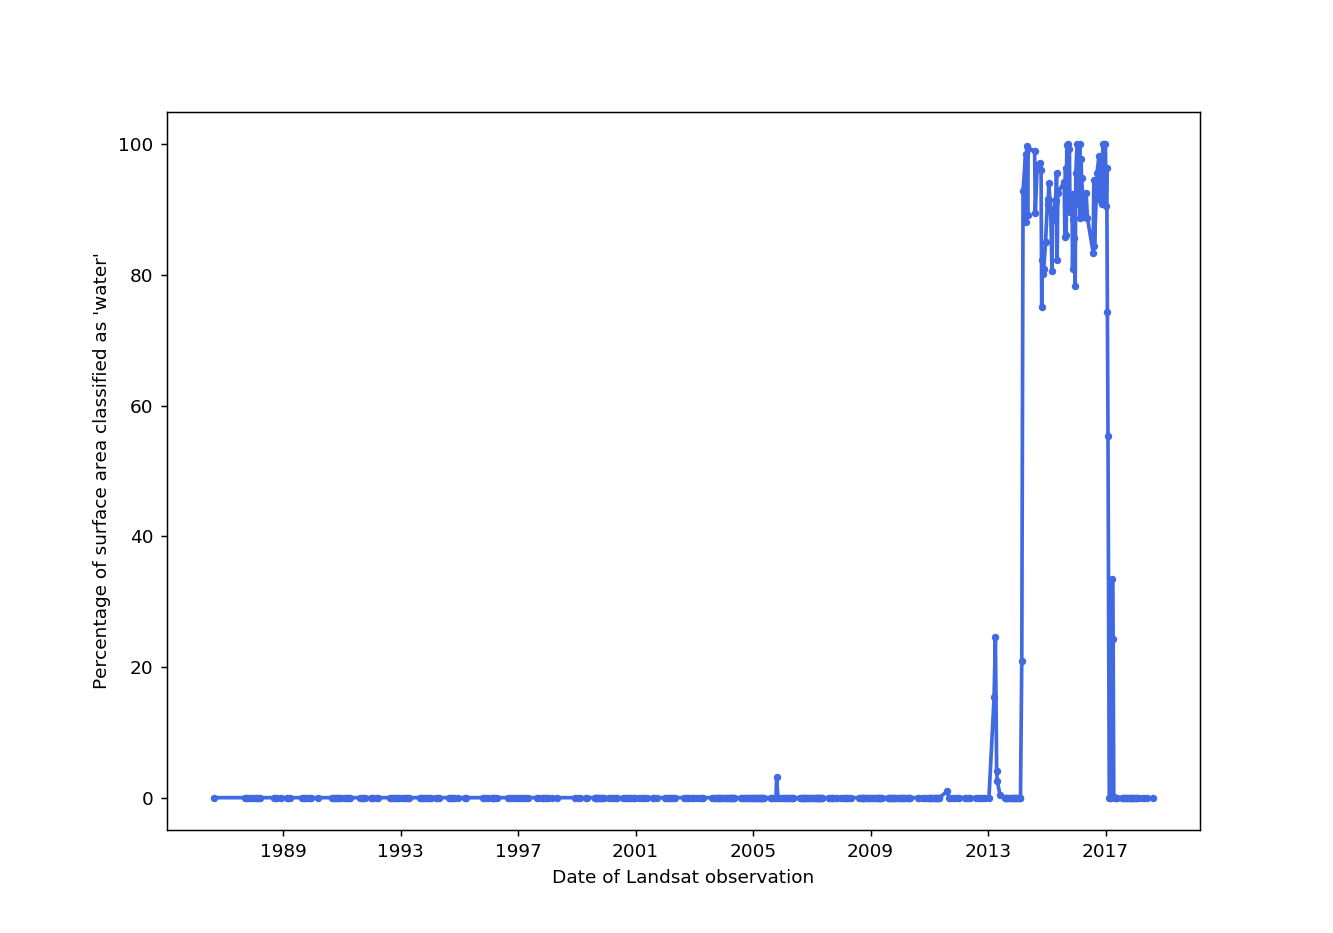

Text(0.5,0,'Date of Landsat observation')

In [14]:
## Plot up the timeseries
fig = plt.figure(figsize=(10, 7)) 
plt.plot(ValidObs.time.values, ValidCapacity, '.-', color = 'royalblue', linewidth = 2)
#plt.plot(ValidObs.time.values, RainValue, '.--', color = 'k', linewidth = 3)
#plt.title('Dam ID : {0}, Surface Area = {1} m2'.format(polyName, polyArea))
plt.ylabel('Percentage of surface area classified as \'water\'')
plt.xlabel('Date of Landsat observation')
#savefig('{}_Timeseries.jpg'.format(polyName.replace(" ", "")))
# plt.close()

<IPython.core.display.Javascript object>


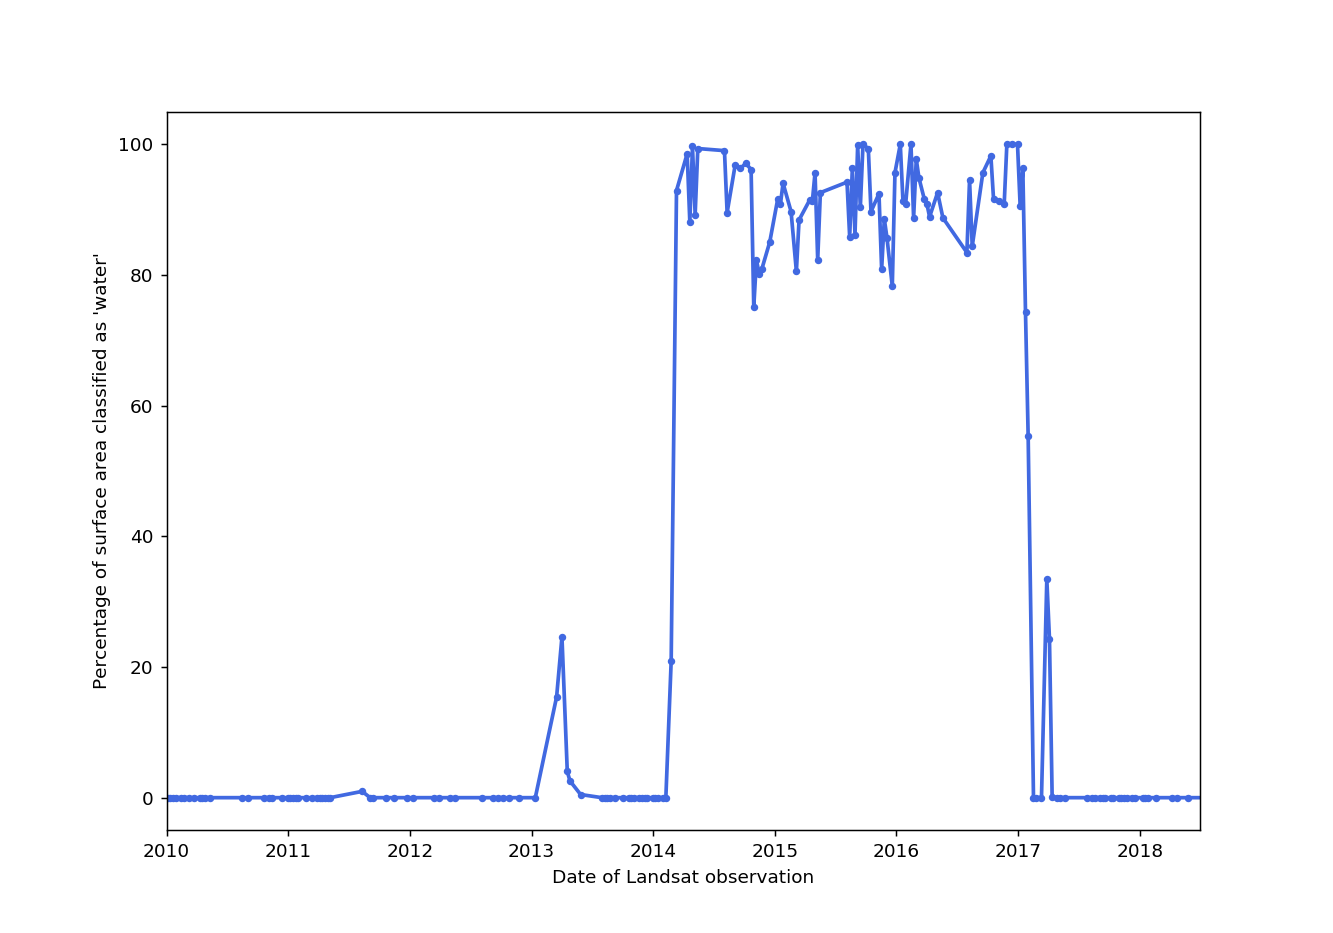

Text(0.5,0,'Date of Landsat observation')

In [16]:
## Plot up the timeseries
fig = plt.figure(figsize=(10, 7)) 
plt.plot(ValidObs.time.values, [DamCapacity[i] for i in ValidMask], '.-', color = 'royalblue', linewidth = 2)
#plt.plot(ValidObs.time.values, RainValue, '.--', color = 'k', linewidth = 3)
plt.xlim(['2010-01-01', '2018-07-01'])
#plt.title('Dam ID : {0}, Surface Area = {1} m2'.format(polyName, polyArea))
plt.ylabel('Percentage of surface area classified as \'water\'')
plt.xlabel('Date of Landsat observation')
#savefig('{}_Timeseries_Zoom.jpg'.format(polyName.replace(" ", "")))